In [1]:
#Import numpy for arrays
import numpy as np
#Import matplotlib.pyplot for plotting
import matplotlib.pyplot as plt
#Import Landlab raster arrays
from landlab import RasterModelGrid 
#Import landlab graph plotting
from landlab.plot.graph import plot_graph
from landlab import imshow_grid

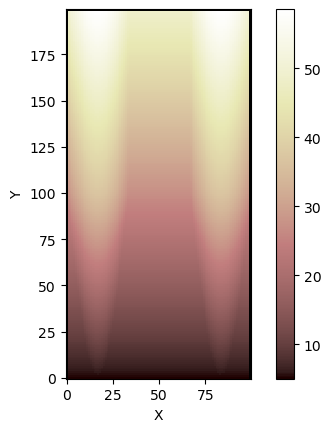

In [2]:
#define the grid
size_x = 100
size_y = 200
spacing = 1.0
grid = RasterModelGrid((size_y, size_x), xy_spacing=spacing)

# morph the grid with a sine function
ice_height = 10
bedrock_slope = 0.22
soil_thickness = 5
moraine_disappears_at_y = 100

# add the topography    
z_ice = grid.add_zeros('ice_thickness', at='node')
z_soil = grid.add_zeros('soil__depth', at='node')
z_bed = grid.add_zeros('bedrock_thickness', at='node')
elev = grid.add_zeros('topographic__elevation', at='node')

x = grid.x_of_node
y = grid.y_of_node

# setting ice elevation respected to the base elevation
z = ice_height * np.sin(np.pi*x / (size_x/3)) 
# get z where y is less than moraine_disappears_at_y
z[y<moraine_disappears_at_y] += (y[y<moraine_disappears_at_y] - moraine_disappears_at_y) * ice_height/moraine_disappears_at_y
z[z<0] = 0 # cut the sine function at 0

z_ice += z
z_soil += soil_thickness
z_bed += bedrock_slope * y
def calc_elev(z_ice, z_soil, z_bed):
    elev = z_ice + z_soil + z_bed
    return elev

elev = calc_elev(z_ice,z_soil,z_bed)    

# add boundaries
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_CLOSED
# grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED

grid.imshow(elev)

In [3]:
#create ThawIce class
class ThawIce:
    #define function and input
    def __init__ (self, grid):
        self.grid = grid
    #define thaw function and inputs (dt is number of days
    def calc_thaw_rate(self, ice_thickness, soil_thickness, thaw_days_per_year):
        self.ice_thickness = ice_thickness 
        self.soil_thickness = soil_thickness
        self.thaw_days = thaw_days_per_year
        
        thaw_rate = []
        for i in range(len(self.soil_thickness)):
            if self.soil_thickness[i] <= 0.05: #m
                thaw_rate.append(self.thaw_days * 0.06) #m/yr
            elif  0.05 < self.soil_thickness[i] < .517:
                thaw_rate.append(0.0857*self.soil_thickness[i]*self.thaw_days)
            elif self.soil_thickness[i] >= .517:
                thaw_rate.append(0)
        self.thaw_rate = np.array(thaw_rate)
    def thaw(self, timestep_years):
        self.dt = timestep_years
        for i in range(len(self.ice_thickness)):
            if self.ice_thickness[i] >= self.thaw_rate[i]*self.dt:
               self.ice_thickness[i] = self.ice_thickness[i] - self.dt*self.thaw_rate[i]
            else:
               self.ice_thickness[i] = 0

Let's begin by initiating our new class. We can use a reasonable assumption of 100 thaw days per year and a timestep of one year.

In [4]:
melt = ThawIce(grid)

Before we actually begin thawing, let's visualize our initial ice thickness.

Notice, the maximum ice thickness is underneath the moraines is:


np.float64(9.995065603657316)

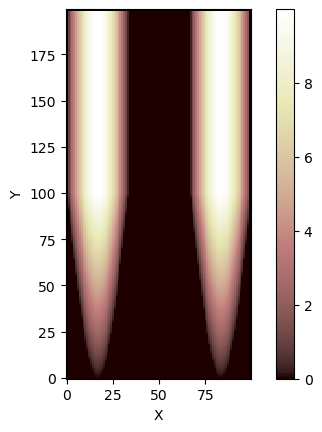

In [5]:
imshow_grid(grid, z_ice)
print("Notice, the maximum ice thickness is underneath the moraines is:")
max(z_ice)

Now, let's thaw one timestep. To do this, we first call the calc_thaw_rate function then use the calculated thaw rate in the thaw function.

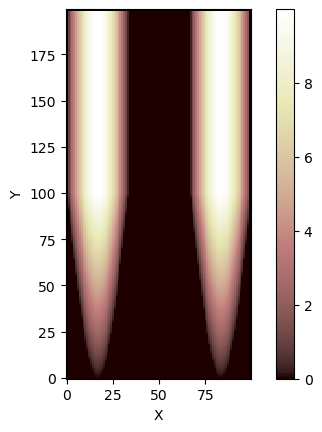

In [6]:
melt.calc_thaw_rate(ice_thickness = z_ice, soil_thickness = z_soil, thaw_days_per_year = 100)
melt.thaw(timestep_years = 1)

imshow_grid(grid, melt.ice_thickness)

###What Happened?
Did the ice thaw? No, it didn't. Why do you think that is? Why don't we examine the thaw rates to find out.

They're all zero!


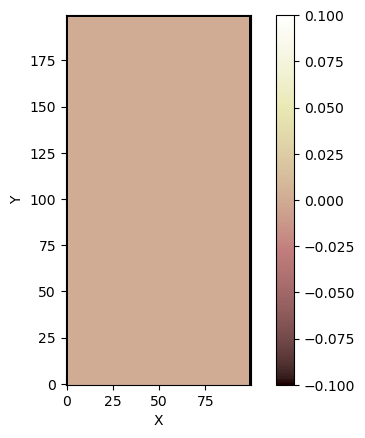

In [7]:
imshow_grid(grid, melt.thaw_rate)
print("They're all zero!")

Look back at the calc_thaw_rate function. Notice how it depends on soil thickness. What soil thickness value have we chosen? Why don't we plot it:

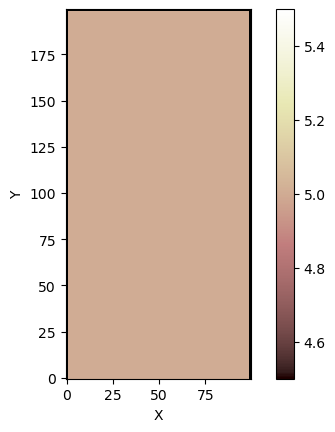

In [8]:
grid.imshow(grid.at_node['soil__depth'])

Soil thickness is 5 m. This is much larger than the 0.517 m limit for soil thickness above which ice does not thaw. This is due to insolation from atmospheric warming. 

To investigate thawing rates, why don't we change soil thickness to 0.1.

In [9]:
z_soil -= 4.9
melt.calc_thaw_rate(ice_thickness = z_ice, soil_thickness = z_soil, thaw_days_per_year = 100)

Now let's plot the thawing rate.

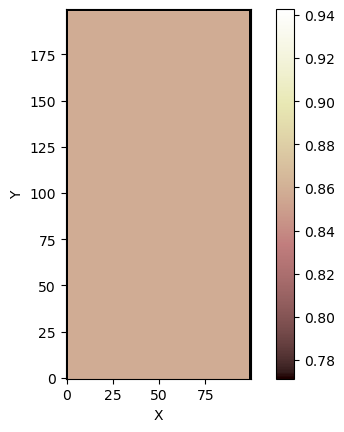

In [10]:
imshow_grid(grid, melt.thaw_rate)

That looks more realistic. Why don't we thaw and plot the new ice thickness.

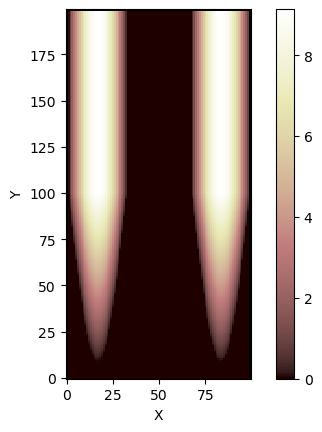

In [11]:
melt.thaw(timestep_years = 1)
imshow_grid(grid, melt.ice_thickness)

Not so different. However, if we call the maximum ice thickness, we get a different answer:

In [12]:
max(melt.ice_thickness)

np.float64(9.138065603657319)

It's now 9.13 m not 9.99 m! This means the ice has thawed.

Now why don't we continue and try thawing another 4 years.

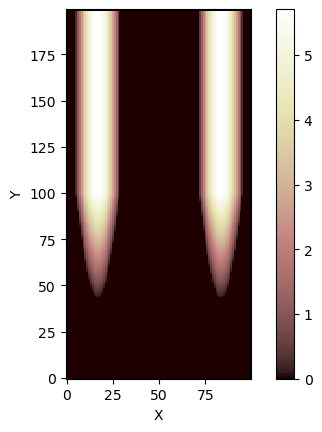

In [13]:
melt.calc_thaw_rate(ice_thickness = z_ice, soil_thickness = z_soil, thaw_days_per_year = 100)
melt.thaw(timestep_years = 4)
imshow_grid(grid, melt.ice_thickness)

Notice the ice has retreated and thinned.

Now let's run another 10 years. That will put us at 10 years total of thawing. 

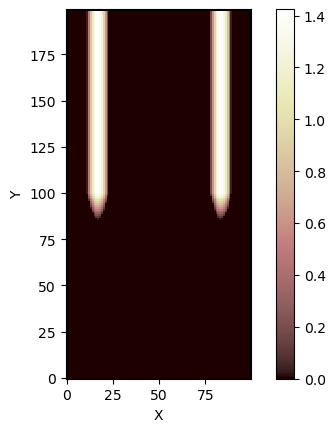

In [14]:
melt.thaw(timestep_years = 5)
imshow_grid(grid, melt.ice_thickness)

You can see how the ice continues to retreat! Let's now examine the final topography after 10 years of thawing.

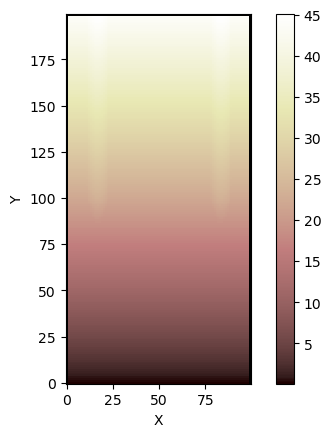

In [16]:
elev = calc_elev(melt.ice_thickness, z_soil, z_bed)
grid.imshow(elev)

Now the topography has mostly flattened only due to ice thawing.